# Seminário prático - Experimentos sobre meta-aprendizado

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from importlib import reload
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, accuracy_score

import aux
from aux import preprocess_default, ALL_ACC, ALL_ACC_SET, \
    drop_draw_set_class, drop_all_vs_rf, print_counter, \
    show_metrics, show_most_important_features
from itertools import combinations
from sklearn.metrics import precision_recall_fscore_support

In [2]:
data = pd.read_csv("meta-base.csv")
data

,general.attrToInst,general.catToNum,general.freqClass.mean,general.freqClass.sd,general.instToAttr,general.nrAttr,general.nrBin,general.nrCat,general.nrClass,general.nrInst,...,C4.5.auc,kNN.acc,kNN.f1m,kNN.auc,SVM.acc,SVM.f1m,SVM.auc,RF.acc,RF.f1m,RF.auc
0,0.100000,0.000000,0.5,0.471405,10.000000,60,0,0,2,600,...,0.993992,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.042056,0.000000,0.5,0.204863,23.777778,9,0,0,2,214,...,0.786753,0.789214,0.764841,0.879050,0.770022,0.733372,0.835946,0.848485,0.822825,0.916196
2,0.121622,5.000000,0.5,0.066888,8.222222,18,9,15,2,148,...,0.813973,0.807071,0.803779,0.887428,0.846863,0.843160,0.927110,0.866887,0.861265,0.941109
3,0.492063,0.148148,0.5,0.145911,2.032258,31,0,4,2,63,...,0.662129,0.663429,0.680036,0.749489,0.761619,0.750802,0.827020,0.785238,0.771251,0.833724
4,0.020833,0.000000,0.5,0.105224,48.000000,7,2,0,2,336,...,0.959853,0.942531,0.941450,0.977326,0.966627,0.965831,0.985190,0.965199,0.964476,0.987683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.223881,0.071429,0.5,0.158307,4.466667,15,1,1,2,67,...,0.779784,0.768214,0.757795,0.843975,0.697202,0.701777,0.808815,0.798333,0.784645,0.858558
396,0.003472,0.000000,0.5,0.283170,288.000000,6,0,6,2,1728,...,0.982767,0.877835,0.844500,0.955360,0.957931,0.950636,0.993741,0.989701,0.987869,0.999346
397,0.021277,0.000000,0.5,0.342688,47.000000,18,0,0,2,846,...,0.969553,0.970795,0.962234,0.993139,0.979193,0.972641,0.996332,0.986998,0.982835,0.998817
398,0.023500,0.000000,0.5,0.565685,42.553191,47,0,0,2,2000,...,0.981546,0.993950,0.983220,0.998558,0.994550,0.984556,0.999174,0.988250,0.965376,0.998578


# Primeiro experimento - 5 Classes

In [3]:
#remove as colunas referentes às medidas f1m e auc
data.drop(data.filter(regex='(.*?\.auc|.*?\.f1m)').columns, axis=1, inplace=True)
data.loc[:, ['landmarking.randomNode.sd', 'landmarking.worstNode.mean', 'landmarking.worstNode.sd', 'ANN.acc', 
             'C4.5.acc', 'kNN.acc', 'SVM.acc', 'RF.acc']]

,landmarking.randomNode.sd,landmarking.worstNode.mean,landmarking.worstNode.sd,ANN.acc,C4.5.acc,kNN.acc,SVM.acc,RF.acc
0,0.038789,0.886667,0.041425,1.000000,0.992000,1.000000,1.000000,1.000000
1,0.089963,0.617662,0.076761,0.708379,0.784846,0.789214,0.770022,0.848485
2,0.123754,0.560536,0.119251,0.837292,0.792357,0.807071,0.846863,0.866887
3,0.160420,0.639048,0.171734,0.767238,0.646000,0.663429,0.761619,0.785238
4,0.110580,0.604069,0.075009,0.961919,0.949307,0.942531,0.966627,0.965199
...,...,...,...,...,...,...,...,...
395,0.160472,0.636310,0.179899,0.770893,0.765179,0.768214,0.697202,0.798333
396,0.018734,0.700249,0.018734,0.999768,0.950167,0.877835,0.957931,0.989701
397,0.041359,0.742169,0.042820,0.982605,0.962633,0.970795,0.979193,0.986998
398,0.008433,0.900000,0.000000,0.994850,0.983450,0.993950,0.994550,0.988250


In [4]:
#remove as amostras com empate (com relação à maior acurácia) e determina as classes
data = drop_draw_set_class(data.copy())
data.loc[:, ['landmarking.randomNode.mean', 'landmarking.randomNode.sd', 'landmarking.worstNode.mean', 'landmarking.worstNode.sd', 'Class']]

,landmarking.randomNode.mean,landmarking.randomNode.sd,landmarking.worstNode.mean,landmarking.worstNode.sd,Class
0,0.655297,0.089963,0.617662,0.076761,RF.acc
1,0.593000,0.123754,0.560536,0.119251,RF.acc
2,0.569762,0.160420,0.639048,0.171734,RF.acc
3,0.674139,0.110580,0.604069,0.075009,SVM.acc
4,0.648228,0.142807,0.643772,0.147598,ANN.acc
...,...,...,...,...,...
378,0.676190,0.160472,0.636310,0.179899,RF.acc
379,0.700249,0.018734,0.700249,0.018734,ANN.acc
380,0.752254,0.041359,0.742169,0.042820,RF.acc
381,0.903000,0.008433,0.900000,0.000000,ANN.acc


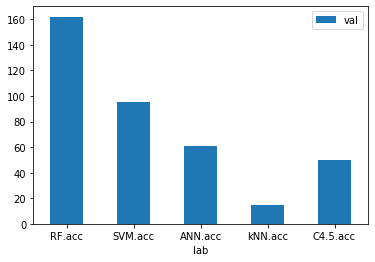

In [5]:
#plota distribuição das classes
X = data.drop('Class', axis=1)
y = data['Class']

vec = list(zip( *[*Counter( y ).items()])) 
gambs = pd.DataFrame(dict(zip(['lab', 'val'],vec))) 
ax = gambs.plot.bar(x='lab', y='val', rot=0) 
plt.show(block=True)

Treinamento/Teste  0  Id:  0
accuracy: 0.40625
precision:  0.2660416666666666
recall:  0.24726851851851853
f1_score:  0.20962918660287083
precision_recall_fscore_support : 
	
	[0.5        0.         0.53333333 0.296875   0.        ]
	[0.05       0.         0.59259259 0.59375    0.        ]
	[0.09090909 0.         0.56140351 0.39583333 0.        ]
	[20 17 54 32  5]
Confusion matrix


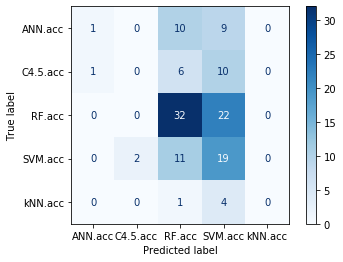


 

Treinamento/Teste  1  Id:  1
accuracy: 0.4375
precision:  0.25239962651727355
recall:  0.27949074074074076
f1_score:  0.26394601625178676
precision_recall_fscore_support : 
	
	[0.38888889 0.         0.55882353 0.31428571 0.        ]
	[0.35      0.        0.7037037 0.34375   0.       ]
	[0.36842105 0.         0.62295082 0.32835821 0.        ]
	[20 17 54 32  5]
Confusion matrix


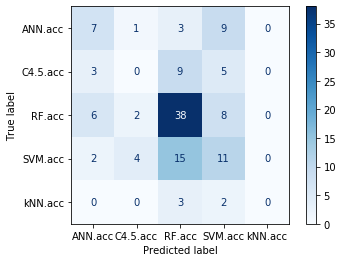


 

Treinamento/Teste  2  Id:  2
accuracy: 0.4881889763779528
precision:  0.2921611721611722
recall:  0.28346134152585767
f1_score:  0.2662302182242212
precision_recall_fscore_support : 
	
	[0.33333333 0.         0.52747253 0.6        0.        ]
	[0.23809524 0.         0.88888889 0.29032258 0.        ]
	[0.27777778 0.         0.66206897 0.39130435 0.        ]
	[21 16 54 31  5]
Confusion matrix


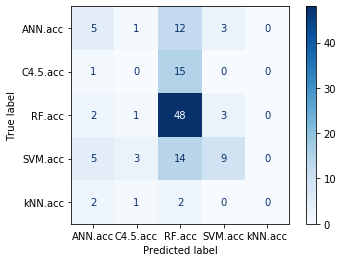


 

------------------------
Considered classes : All 

Mean accuracy =  0.0 



In [6]:
#aplicação do algoritmo Random Forest usando 3-folds cross validation seguido da avaliação das predições

rfc = RandomForestClassifier(n_estimators=200)
k = 0
acc = 0
acc_sum = 0   
n_splits = 3

skf = StratifiedKFold(n_splits=n_splits)
features_list = []
iii = 0
for k, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Treinamento/Teste ", k, " Id: ", iii)
    iii += 1
    rfc.fit(X.loc[train_index, :].drop('index', axis=1), y.loc[train_index])
    features_list.append(rfc.feature_importances_)
    y_pred = rfc.predict(X.loc[test_index, :].drop('index', axis=1), )
    
    show_metrics(y_true=y.loc[test_index], y_pred=y_pred)
    #matriz de confusão
    print("Confusion matrix")  
    disp = plot_confusion_matrix(rfc, X.loc[test_index, :].drop('index', axis=1), y.loc[test_index],
                                 display_labels=None,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    plt.show()
    print("\n \n")

#printa as médias das medidas tiradas nos 10 folds
print("------------------------")
print("Considered classes : All \n")
print("Mean accuracy = ", acc_sum / n_splits, "\n")

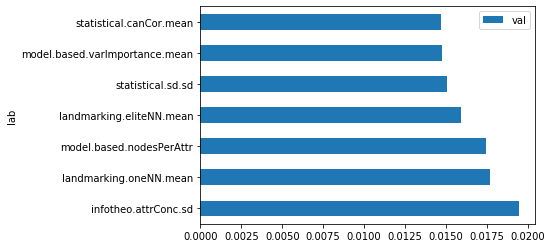

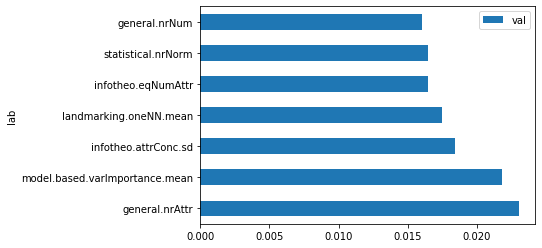

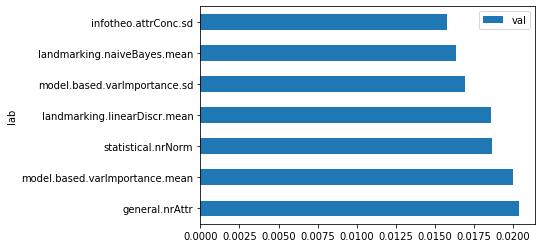

In [7]:
#exibe as características mais informativas da base em cada fold
show_most_important_features(X, features_list=features_list)


# Segundo experimento - Classes dois a dois

Considered classes
RF.acc -> 246
SVM.acc -> 151


Treinamento/Teste  0  Id:  0
accuracy: 0.44360902255639095
precision:  0.48443223443223443
recall:  0.4857723577235772
f1_score:  0.44104952294411637
precision_recall_fscore_support : 
	
	[0.5952381  0.37362637]
	[0.30487805 0.66666667]
	[0.40322581 0.47887324]
	[82 51]


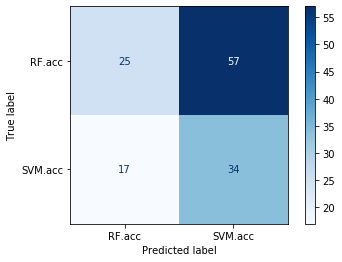


 

Treinamento/Teste  1  Id:  1
accuracy: 0.6515151515151515
precision:  0.6233671988388969
recall:  0.5829268292682926
f1_score:  0.5750279955207166
precision_recall_fscore_support : 
	
	[0.66981132 0.57692308]
	[0.86585366 0.3       ]
	[0.75531915 0.39473684]
	[82 50]


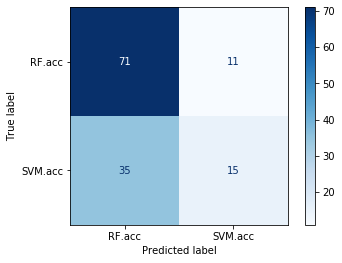


 

Treinamento/Teste  2  Id:  2
accuracy: 0.6666666666666666
precision:  0.6876513317191284
recall:  0.5756097560975609
f1_score:  0.54625
precision_recall_fscore_support : 
	
	[0.66101695 0.71428571]
	[0.95121951 0.2       ]
	[0.78   0.3125]
	[82 50]


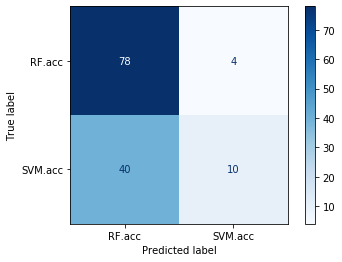


 

Mean accuracy =  0.587263613579403 

-----------------------

Considered classes
RF.acc -> 304
C4.5.acc -> 89


Treinamento/Teste  0  Id:  3
accuracy: 0.7786259541984732
precision:  0.655982905982906
recall:  0.5863759296822177
f1_score:  0.5965806520123182
precision_recall_fscore_support : 
	
	[0.5        0.81196581]
	[0.24137931 0.93137255]
	[0.3255814  0.86757991]
	[ 29 102]


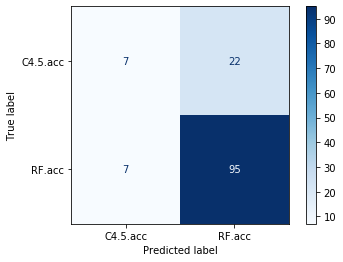


 

Treinamento/Teste  1  Id:  4
accuracy: 0.7633587786259542
precision:  0.6290743155149935
recall:  0.5653465346534654
f1_score:  0.5687586280131677
precision_recall_fscore_support : 
	
	[0.46153846 0.79661017]
	[0.2        0.93069307]
	[0.27906977 0.85844749]
	[ 30 101]


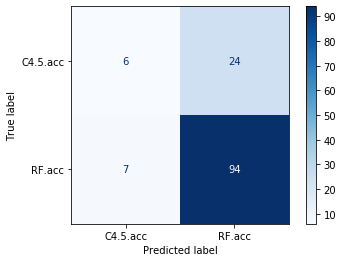


 

Treinamento/Teste  2  Id:  5
accuracy: 0.7938931297709924
precision:  0.7094827586206897
recall:  0.6202970297029703
f1_score:  0.6377880184331797
precision_recall_fscore_support : 
	
	[0.6        0.81896552]
	[0.3        0.94059406]
	[0.4        0.87557604]
	[ 30 101]


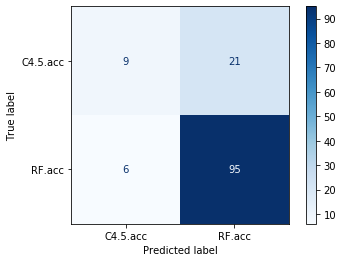


 

Mean accuracy =  0.7786259541984734 

-----------------------

Considered classes
SVM.acc -> 230
C4.5.acc -> 165


Treinamento/Teste  0  Id:  6
accuracy: 0.6363636363636364
precision:  0.7533875338753387
recall:  0.5662337662337662
f1_score:  0.5049999999999999
precision_recall_fscore_support : 
	
	[0.88888889 0.61788618]
	[0.14545455 0.98701299]
	[0.25 0.76]
	[55 77]


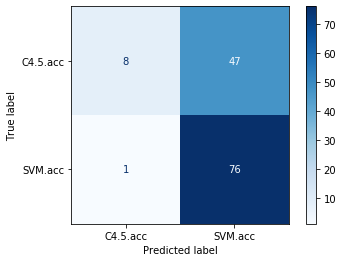


 

Treinamento/Teste  1  Id:  7
accuracy: 0.6893939393939394
precision:  0.6798076923076923
recall:  0.6766233766233767
f1_score:  0.6778379665456277
precision_recall_fscore_support : 
	
	[0.63461538 0.725     ]
	[0.6        0.75324675]
	[0.61682243 0.7388535 ]
	[55 77]


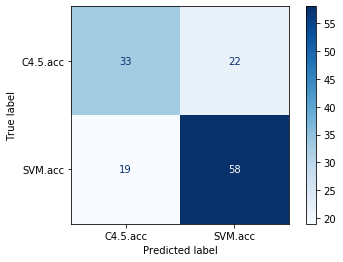


 

Treinamento/Teste  2  Id:  8
accuracy: 0.6564885496183206
precision:  0.7086416490486258
recall:  0.6888755980861244
f1_score:  0.6535817124052417
precision_recall_fscore_support : 
	
	[0.55681818 0.86046512]
	[0.89090909 0.48684211]
	[0.68531469 0.62184874]
	[55 76]


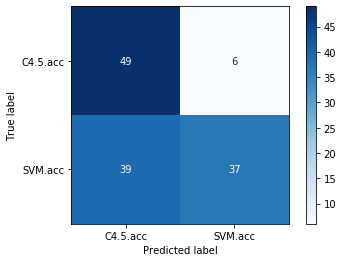


 

Mean accuracy =  0.6607487084586321 

-----------------------

Considered classes
RF.acc -> 347
kNN.acc -> 49


Treinamento/Teste  0  Id:  9
accuracy: 0.8712121212121212
precision:  0.4389312977099237
recall:  0.4956896551724138
f1_score:  0.46558704453441296
precision_recall_fscore_support : 
	
	[0.8778626 0.       ]
	[0.99137931 0.        ]
	[0.93117409 0.        ]
	[116  16]


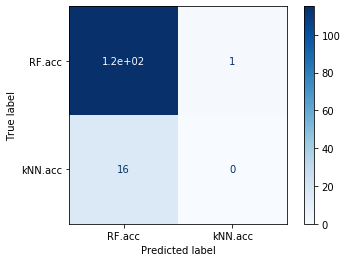


 

Treinamento/Teste  1  Id:  10
accuracy: 0.8787878787878788
precision:  0.6923076923076923
recall:  0.5269396551724138
f1_score:  0.5230352303523035
precision_recall_fscore_support : 
	
	[0.88461538 0.5       ]
	[0.99137931 0.0625    ]
	[0.93495935 0.11111111]
	[116  16]


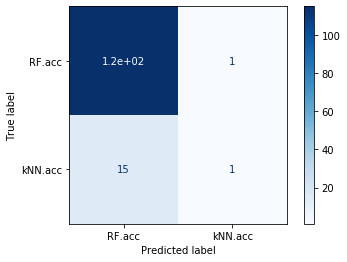


 

Treinamento/Teste  2  Id:  11
accuracy: 0.8636363636363636
precision:  0.6046511627906976
recall:  0.5207161125319693
f1_score:  0.5131147540983607
precision_recall_fscore_support : 
	
	[0.87596899 0.33333333]
	[0.9826087  0.05882353]
	[0.92622951 0.1       ]
	[115  17]


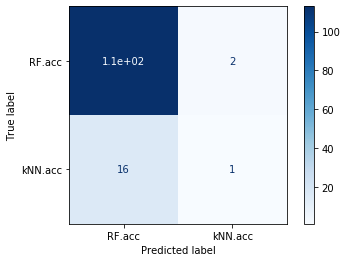


 

Mean accuracy =  0.8712121212121212 

-----------------------

Considered classes
kNN.acc -> 79
SVM.acc -> 317


Treinamento/Teste  0  Id:  12
accuracy: 0.7575757575757576
precision:  0.6048906048906049
recall:  0.5862433862433862
f1_score:  0.5925925925925926
precision_recall_fscore_support : 
	
	[0.82882883 0.38095238]
	[0.87619048 0.2962963 ]
	[0.85185185 0.33333333]
	[105  27]


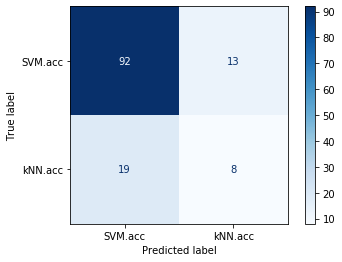


 

Treinamento/Teste  1  Id:  13
accuracy: 0.8257575757575758
precision:  0.7731428571428571
recall:  0.5867198838896952
f1_score:  0.6017316017316017
precision_recall_fscore_support : 
	
	[0.832      0.71428571]
	[0.98113208 0.19230769]
	[0.9004329 0.3030303]
	[106  26]


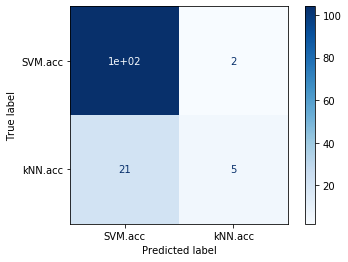


 

Treinamento/Teste  2  Id:  14
accuracy: 0.8181818181818182
precision:  0.9076923076923077
recall:  0.5384615384615384
f1_score:  0.5205811138014528
precision_recall_fscore_support : 
	
	[0.81538462 1.        ]
	[1.         0.07692308]
	[0.89830508 0.14285714]
	[106  26]


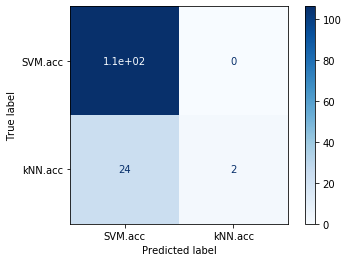


 

Mean accuracy =  0.8005050505050506 

-----------------------

Considered classes
kNN.acc -> 120
C4.5.acc -> 277


Treinamento/Teste  0  Id:  15
accuracy: 0.6541353383458647
precision:  0.6412994093593821
recall:  0.6672043010752688
f1_score:  0.6342659014825442
precision_recall_fscore_support : 
	
	[0.83098592 0.4516129 ]
	[0.6344086 0.7      ]
	[0.7195122  0.54901961]
	[93 40]


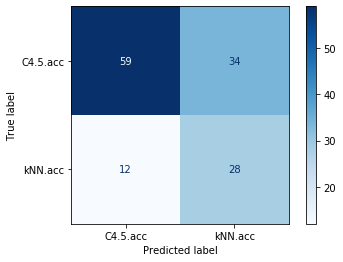


 

Treinamento/Teste  1  Id:  16
accuracy: 0.7196969696969697
precision:  0.6611551001397299
recall:  0.5940217391304348
f1_score:  0.5961967755270774
precision_recall_fscore_support : 
	
	[0.74336283 0.57894737]
	[0.91304348 0.275     ]
	[0.8195122  0.37288136]
	[92 40]


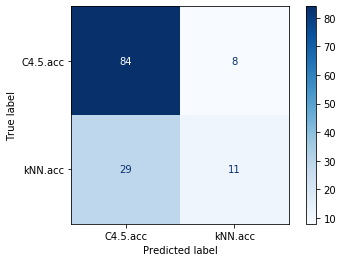


 

Treinamento/Teste  2  Id:  17
accuracy: 0.7272727272727273
precision:  0.6783625730994152
recall:  0.5994565217391304
f1_score:  0.602276531637094
precision_recall_fscore_support : 
	
	[0.74561404 0.61111111]
	[0.92391304 0.275     ]
	[0.82524272 0.37931034]
	[92 40]


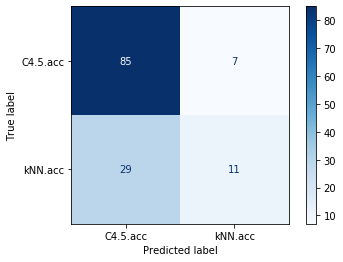


 

Mean accuracy =  0.7003683451051872 

-----------------------

Considered classes
RF.acc -> 271
ANN.acc -> 118


Treinamento/Teste  0  Id:  18
accuracy: 0.7153846153846154
precision:  0.673155737704918
recall:  0.5476190476190477
f1_score:  0.5195285186295076
precision_recall_fscore_support : 
	
	[0.625      0.72131148]
	[0.12820513 0.96703297]
	[0.21276596 0.82629108]
	[39 91]


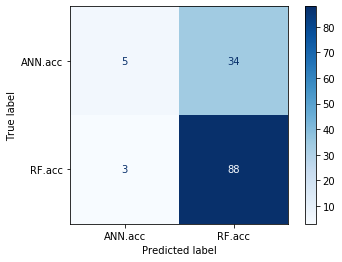


 

Treinamento/Teste  1  Id:  19
accuracy: 0.7076923076923077
precision:  0.6453081232492996
recall:  0.6152777777777778
f1_score:  0.6216299019607843
precision_recall_fscore_support : 
	
	[0.53571429 0.75490196]
	[0.375      0.85555556]
	[0.44117647 0.80208333]
	[40 90]


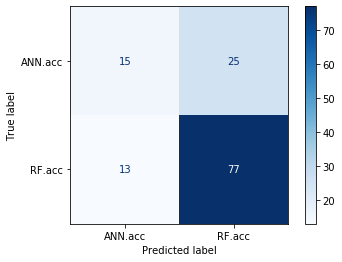


 

Treinamento/Teste  2  Id:  20
accuracy: 0.7131782945736435
precision:  0.6478715459297983
recall:  0.6128205128205129
f1_score:  0.6195296931048226
precision_recall_fscore_support : 
	
	[0.53846154 0.75728155]
	[0.35897436 0.86666667]
	[0.43076923 0.80829016]
	[39 90]


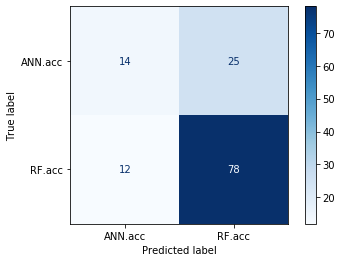


 

Mean accuracy =  0.7120850725501889 

-----------------------

Considered classes
SVM.acc -> 225
ANN.acc -> 170


Treinamento/Teste  0  Id:  21
accuracy: 0.6136363636363636
precision:  0.7358870967741935
recall:  0.5547368421052632
f1_score:  0.47955160417471976
precision_recall_fscore_support : 
	
	[0.875      0.59677419]
	[0.12280702 0.98666667]
	[0.21538462 0.74371859]
	[57 75]


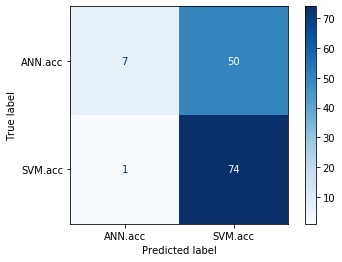


 

Treinamento/Teste  1  Id:  22
accuracy: 0.5909090909090909
precision:  0.5818181818181818
recall:  0.5810526315789474
f1_score:  0.581296992481203
precision_recall_fscore_support : 
	
	[0.52727273 0.63636364]
	[0.50877193 0.65333333]
	[0.51785714 0.64473684]
	[57 75]


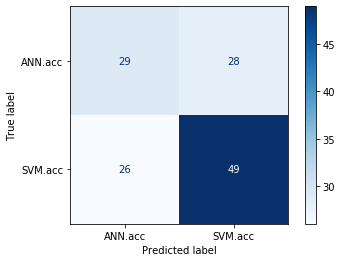


 

Treinamento/Teste  2  Id:  23
accuracy: 0.48091603053435117
precision:  0.6698542805100182
recall:  0.5444047619047618
f1_score:  0.40422685928303903
precision_recall_fscore_support : 
	
	[0.45081967 0.88888889]
	[0.98214286 0.10666667]
	[0.61797753 0.19047619]
	[56 75]


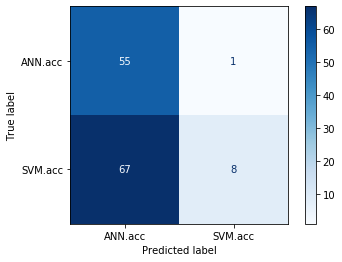


 

Mean accuracy =  0.5618204950266019 

-----------------------

Considered classes
ANN.acc -> 214
C4.5.acc -> 178


Treinamento/Teste  0  Id:  24
accuracy: 0.6870229007633588
precision:  0.6841549295774648
recall:  0.6846751412429379
f1_score:  0.6843744490803314
precision_recall_fscore_support : 
	
	[0.71830986 0.65      ]
	[0.70833333 0.66101695]
	[0.71328671 0.65546218]
	[72 59]


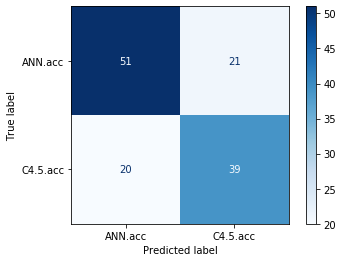


 

Treinamento/Teste  1  Id:  25
accuracy: 0.7022900763358778
precision:  0.7069402228976698
recall:  0.6917840375586854
f1_score:  0.691950557732891
precision_recall_fscore_support : 
	
	[0.69047619 0.72340426]
	[0.81690141 0.56666667]
	[0.7483871  0.63551402]
	[71 60]


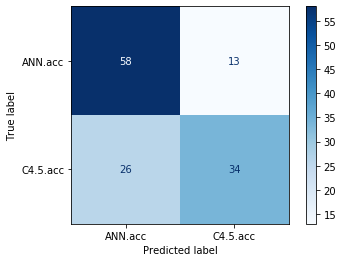


 

Treinamento/Teste  2  Id:  26
accuracy: 0.7230769230769231
precision:  0.7385585091805975
recall:  0.7078061589878253
f1_score:  0.7075
precision_recall_fscore_support : 
	
	[0.69662921 0.7804878 ]
	[0.87323944 0.54237288]
	[0.775 0.64 ]
	[71 59]


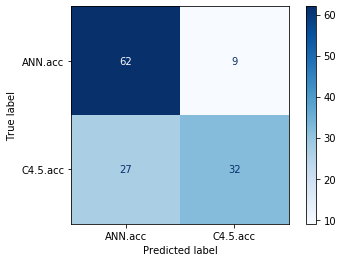


 

Mean accuracy =  0.7041299667253865 

-----------------------

Considered classes
kNN.acc -> 82
ANN.acc -> 313


Treinamento/Teste  0  Id:  27
accuracy: 0.6742424242424242
precision:  0.5500736377025037
recall:  0.5583791208791209
f1_score:  0.5517649846008055
precision_recall_fscore_support : 
	
	[0.81443299 0.28571429]
	[0.75961538 0.35714286]
	[0.78606965 0.31746032]
	[104  28]


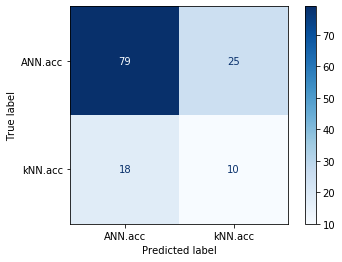


 

Treinamento/Teste  1  Id:  28
accuracy: 0.8181818181818182
precision:  0.9069767441860466
recall:  0.5555555555555556
f1_score:  0.5487179487179487
precision_recall_fscore_support : 
	
	[0.81395349 1.        ]
	[1.         0.11111111]
	[0.8974359 0.2      ]
	[105  27]


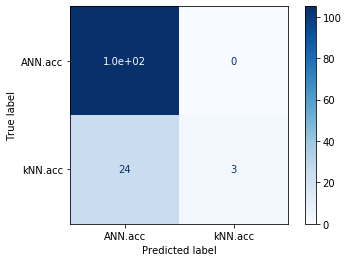


 

Treinamento/Teste  2  Id:  29
accuracy: 0.7862595419847328
precision:  0.39615384615384613
recall:  0.4951923076923077
f1_score:  0.4401709401709402
precision_recall_fscore_support : 
	
	[0.79230769 0.        ]
	[0.99038462 0.        ]
	[0.88034188 0.        ]
	[104  27]


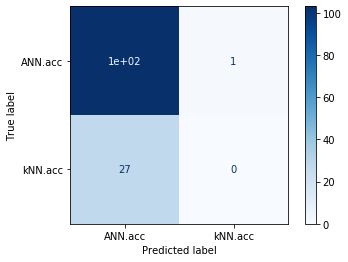


 

Mean accuracy =  0.7595612614696584 

-----------------------



In [8]:
from sklearn.metrics import precision_recall_fscore_support
reload(aux)
comb_to_drop = list(combinations(ALL_ACC, r=3))
raw = pd.read_csv('meta-base.csv')

features_list = []
acc_mean_list = []
#para cada combinação de 3 colunas, dropa essas 3 deixando 2 colunas para o problema de classificação
#faz o pre_processamento do dataframe passando as colunas consideradas
# (retira os empates e seta as classes)
# divide o data em features e rótulo e divide os folds
iii = 0
for to_drop in comb_to_drop:
    data = raw.drop(list(to_drop), axis=1)
    considered_classes = ALL_ACC_SET - set(to_drop)
    data = preprocess_default(data, list(considered_classes))
    rfc = RandomForestClassifier(n_estimators=200)
    X = data.drop('Class', axis=1)
    y = data['Class']
    n_splits = 3
    skf = StratifiedKFold(n_splits=n_splits)
    acc_list = []
    print("Considered classes")
    print_counter(y)
    print("\n")
    
    for k, (train_index, test_index) in enumerate(skf.split(X, y)):
        print("Treinamento/Teste ", k, " Id: ", iii)
        iii += 1
        rfc.fit(X.loc[train_index, :], y.loc[train_index])
        features_list.append(rfc.feature_importances_)
        y_pred = rfc.predict(X.loc[test_index, :], )
        
        acc_list.append(accuracy_score(y_true=y.loc[test_index], y_pred=y_pred))
        
        aux.show_metrics(y_true=y.loc[test_index], y_pred=y_pred)
        
        #matriz de confusão
        disp = plot_confusion_matrix(rfc, X.loc[test_index, :], y.loc[test_index],
                                 display_labels=None,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
        plt.show()
        print("\n \n")

    print("Mean accuracy = ", np.mean(acc_list) , "\n")
    acc_mean_list.append(np.mean(acc_list))
    print("-----------------------\n")
 
    

7 : C4.5 x SVM
8 : C4.5 x SVM
24 : ANN x C4.5
25 : ANN x C4.5


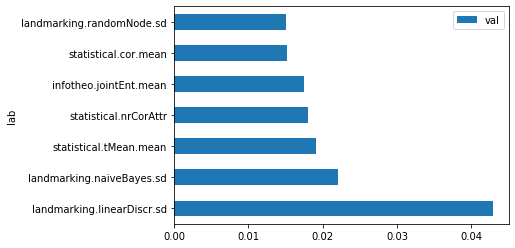

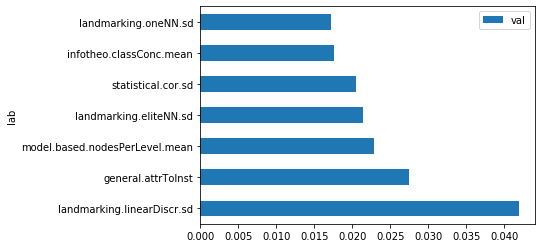

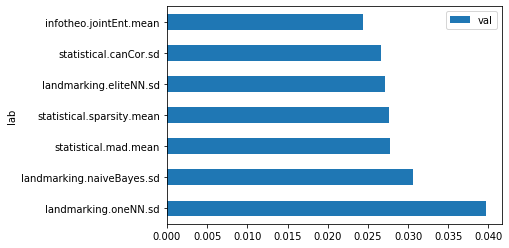

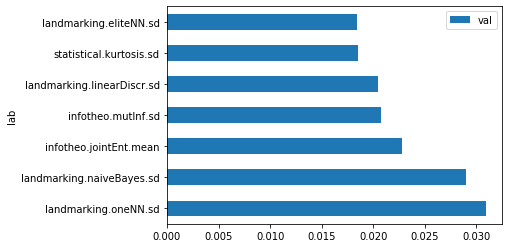

In [13]:
best_matrix = [7, 8, 24, 25]

show_most_important_features(
    X, map(lambda x: features_list[x], best_matrix)
)
print("7 : C4.5 x SVM")
print("8 : C4.5 x SVM")
print("24 : ANN x C4.5")
print("25 : ANN x C4.5")

14 é das mais DESBALANCEADAS (ANN x C4.5)


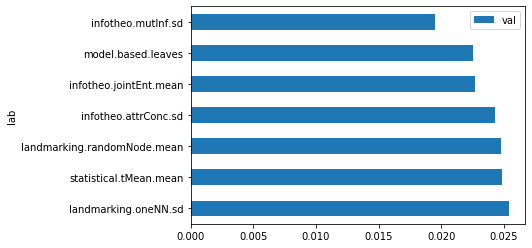

In [10]:
worst_matrix = [14]

show_most_important_features(
    X, map(lambda x: features_list[x], worst_matrix)
)
print("14 é das mais DESBALANCEADAS (ANN x C4.5)")

# Terceiro experimento - Random Forest x Outros

Considered classes
RF.acc -> 162
Other -> 221


Treinamento/Teste  0  Id:  0
accuracy: 0.5844155844155844
precision:  0.5711206896551724
recall:  0.5681818181818181
f1_score:  0.5680224403927069
precision_recall_fscore_support : 
	
	[0.625      0.51724138]
	[0.68181818 0.45454545]
	[0.65217391 0.48387097]
	[44 33]


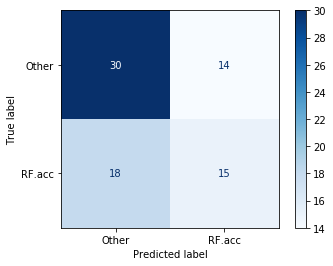


 

Treinamento/Teste  1  Id:  1
accuracy: 0.7272727272727273
precision:  0.7244897959183674
recall:  0.7121212121212122
f1_score:  0.7149656266525648
precision_recall_fscore_support : 
	
	[0.73469388 0.71428571]
	[0.81818182 0.60606061]
	[0.77419355 0.6557377 ]
	[44 33]


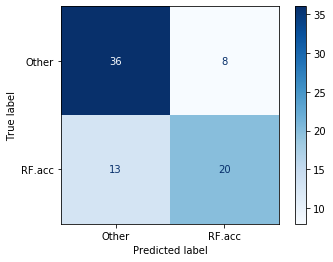


 

Treinamento/Teste  2  Id:  2
accuracy: 0.7012987012987013
precision:  0.6957692307692308
recall:  0.6767361111111111
f1_score:  0.6796889130041599
precision_recall_fscore_support : 
	
	[0.71153846 0.68      ]
	[0.82222222 0.53125   ]
	[0.7628866  0.59649123]
	[45 32]


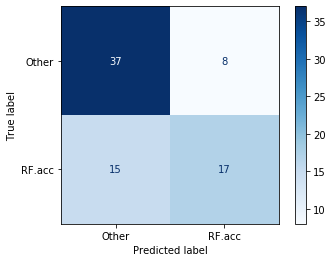


 

Treinamento/Teste  3  Id:  3
accuracy: 0.6710526315789473
precision:  0.6617535903250189
recall:  0.6519886363636364
f1_score:  0.6537269910698014
precision_recall_fscore_support : 
	
	[0.69387755 0.62962963]
	[0.77272727 0.53125   ]
	[0.7311828  0.57627119]
	[44 32]


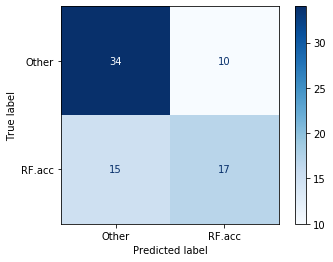


 

Treinamento/Teste  4  Id:  4
accuracy: 0.7105263157894737
precision:  0.7061538461538461
recall:  0.6903409090909092
f1_score:  0.6933235509904623
precision_recall_fscore_support : 
	
	[0.72       0.69230769]
	[0.81818182 0.5625    ]
	[0.76595745 0.62068966]
	[44 32]


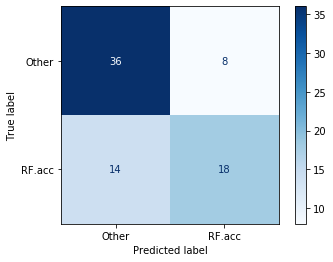


 

Mean accuracy =  0.6789131920710869 

-----------------------



In [11]:
data_rf_all = drop_all_vs_rf(pd.read_csv('meta-base.csv'))
data_rf_all.drop(data_rf_all.filter(regex='(.*?\.auc|.*?\.f1m)').columns, axis=1, inplace=True)

#para cada combinação de 3 colunas, dropa essas 3 deixando 2 colunas para o problema de classificação
#faz o pre_processamento do dataframe passando as colunas consideradas (retira os empates e seta as classes)
#divide o data em features e rótulo e divide os folds
data = data_rf_all
rfc = RandomForestClassifier(n_estimators=1000)
X = data.drop('Class', axis=1)
y = data['Class']
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, random_state=42,
                      shuffle=True)
acc_list = []
print("Considered classes")
print_counter(y)
print("\n")
iii = 0
for k, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Treinamento/Teste ", k, " Id: ", iii)
    iii += 1    
    rfc.fit(X.loc[train_index, :], y.loc[train_index])
    features_list.append(rfc.feature_importances_)
    y_pred = rfc.predict(X.loc[test_index, :], )
    
    acc_list.append(accuracy_score(y_true=y.loc[test_index], y_pred=y_pred))

    aux.show_metrics(y_true=y.loc[test_index], y_pred=y_pred)
    
    #matriz de confusão
    disp = plot_confusion_matrix(rfc, X.loc[test_index, :], y.loc[test_index],
                             display_labels=None,
                             cmap=plt.cm.Blues,
                             normalize=None)
    plt.show()
    print("\n \n")

print("Mean accuracy = ", np.mean(acc_list), "\n")
print("-----------------------\n")


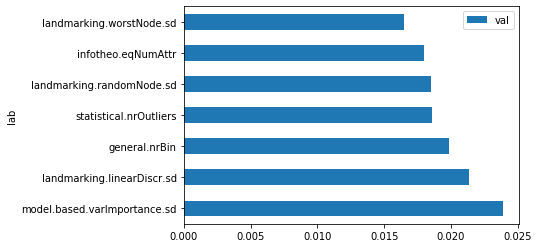

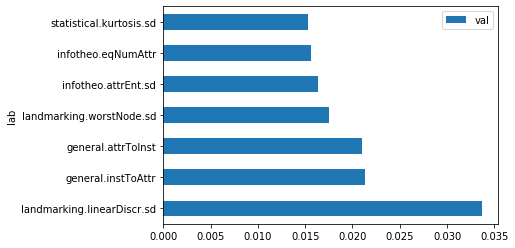

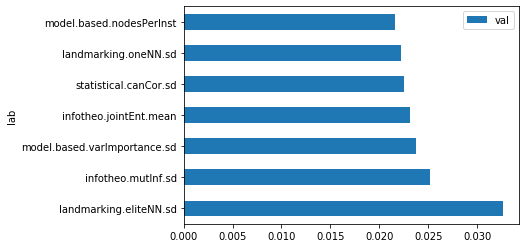

In [12]:
matrix = [1, 2, 3]

show_most_important_features(
    X, map(lambda x: features_list[x], matrix)
)